## Get MinIO credentials
- Login at `https://console.example.com/login`
- Setup your Minio CLI

In [ ]:
import hashlib
import os
username = os.environ['JUPYTERHUB_USER']
hash_object = hashlib.md5(f'{username}'.encode())
password = hash_object.hexdigest()
print(f"Username: {username}\npassword: {password}")

## Initiate a local Dask scheduler on this machine

In [3]:
from distributed import Client
c_local = Client()
c_local

2022-11-05 20:23:18,364 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-y3wczw00', purging
2022-11-05 20:23:18,365 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-fzpw3pfn', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 2.44 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37609,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 2.44 GiB
Comm: tcp://127.0.0.1:35721,Total threads: 1
Dashboard: http://127.0.0.1:36471/status,Memory: 1.22 GiB
Nanny: tcp://127.0.0.1:39579,


## Initiate a distributed scheduler with 6 workers

In [4]:
from dask_kubernetes.operator import KubeCluster

cluster = KubeCluster(
    name=f'{username}',
    namespace=f'user-{username}', 
    image='dodasts/sosc22:v1',
    n_workers=6,
    worker_command=[
        'dask-worker',
        '--name=$(DASK_WORKER_NAME)',
        '--local-directory=temp_dir', 
        '--nthreads', '1',
        '--death-timeout', '60',
        '--memory-limit','2G'
    ],
    port_forward_cluster_ip=True,
    resources={
        "requests": {
            "memory": "2Gi",
            "cpu": "1"
        },
        "limits": {
            "memory": "3Gi",
            "cpu": "1"
        }
    }
)

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7faa74091990>


In [5]:
c_distributed = Client(cluster)
c_distributed

<Client: 'tcp://10.42.49.23:8786' processes=12 threads=12, memory=22.35 GiB>

## Define the data processing functions

In [6]:
from subprocess import run as run_shell
import ctypes
import random
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import dask.array as da
from dask.distributed import Client
from dask.distributed import get_client
import dask.bag as db
import os
import glob

def butt_filtfilt(data):
    b, a = butter(4, 0.5/24)
    filtered = filtfilt(b, a, np.asarray(data))
    hf = data - filtered
    #hf = (hf - hf.mean(axis=1, keepdims=True))/hf.std(axis=1, keepdims=True)
    #hf = (hf - hf.mean(axis=0, keepdims=True))/hf.std(axis=0, keepdims=True)
    return hf

def create_hf(hf):
    hf = np.asarray(hf)
    hf = (hf - hf.mean(axis=1, keepdims=True))/hf.std(axis=1, keepdims=True)
    hf = (hf - hf.mean(axis=0, keepdims=True))/hf.std(axis=0, keepdims=True)
    return hf


alpha = 0.5
print("""
    #include <math.h>

    extern "C"
    int best_matching_period (int n, double alpha, double* lumi) {
        int i, j, k, best_period;
        double score, min_score = 9999.;
        
        for (i = 100; i < n/2; ++i)
            for (j = 1; j < i; ++j) {
                score = 0;
                for (k = j; k < n; k+= i) score += lumi[k];
                score /= pow(n/i, alpha);
                
                if (score < min_score) {
                    min_score = score;
                    best_period = i;
                }
            }
        return best_period;
    }
    """, file=open('src.C', 'w'))
    
libpath = f"lib.{random.randint(0,0x7FFFF)}.so"
run_shell(['gcc', '--shared', '-fPIC', '-o', "/tmp/" + libpath, 'src.C'])
c_distributed.upload_file("/tmp/" + libpath)

def compute_period(data, dask_distributed=False):
    
    if dask_distributed:
        path = glob.glob("/home/jovyan/temp_dir/dask-worker-space/worker-*/" + libpath)[0]
    else:
        path = "/tmp/" + libpath
    lib = ctypes.cdll.LoadLibrary(path)
    lib.best_matching_period.restype = ctypes.c_int
    lib.best_matching_period.argtypes = [
        ctypes.c_int, 
        ctypes.c_double, 
        np.ctypeslib.ndpointer(dtype=np.float64)
    ]
    

    return lib.best_matching_period(len(data), alpha, data);


## Load data and labels

In [7]:

df =  pd.read_csv("https://pandora.infn.it/public/806aa1/dl/exoTrain.csv")
data = df[df.columns[1:]].values[:]
label = df.LABEL.values

len(data)

5087

## Local vs distributed for first preprocessing task

### Distributed

In [8]:
%%time
import dask
from distributed.client import temp_default_client

with temp_default_client(c_distributed):
    b = db.from_sequence(data, npartitions=30)
    b = b.map(butt_filtfilt)

    hf = b.compute()
    hf = np.asarray(hf)
    hf = (hf - hf.mean(axis=1, keepdims=True))/hf.std(axis=1, keepdims=True)
    preprocessed_array_dist = (hf - hf.mean(axis=0, keepdims=True))/hf.std(axis=0, keepdims=True)

CPU times: user 1.71 s, sys: 324 ms, total: 2.03 s
Wall time: 4.59 s


### Local

In [9]:
%%time
with temp_default_client(c_local):
    b = db.from_sequence(data, npartitions=10)
    b = b.map(butt_filtfilt)

    hf = b.compute()
    hf = np.asarray(hf)
    hf = (hf - hf.mean(axis=1, keepdims=True))/hf.std(axis=1, keepdims=True)
    preprocessed_array_local = (hf - hf.mean(axis=0, keepdims=True))/hf.std(axis=0, keepdims=True)

CPU times: user 1.64 s, sys: 283 ms, total: 1.92 s
Wall time: 3.77 s


## Local vs Distributed on compute period function

### Distributed

In [10]:
%%time

def map_fn(fn, x):
    ...

    # Get locally created client
    client = get_client()

    # Do normal client operations, asking cluster for computation
    futures = client.map(fn, (x))
    array = client.gather(futures)

    return array

from functools import partial

with temp_default_client(c_distributed):
    preprocessed_array_scattered = c_distributed.scatter(preprocessed_array_dist)
    get_periods = dask.delayed(map_fn)(partial(compute_period, dask_distributed=True), preprocessed_array_scattered)

    periods = np.array(get_periods.compute())

CPU times: user 647 ms, sys: 104 ms, total: 750 ms
Wall time: 26.4 s


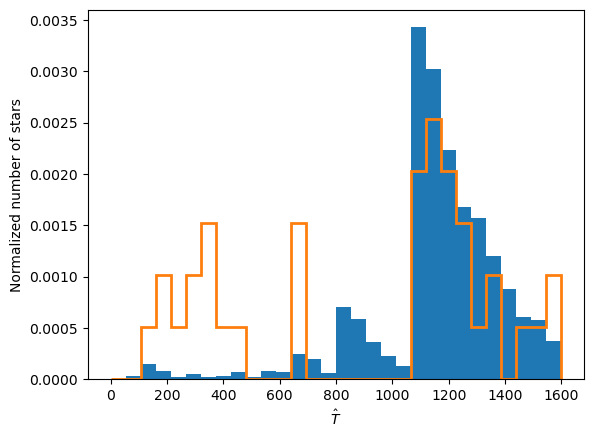

In [11]:
bins = np.linspace(0, 1600, 31)
plt.hist(periods, bins=bins, density=True)
plt.hist(periods[label == 2], bins=bins, density=True, histtype='step', linewidth=2)
plt.xlabel("$\hat T$")
plt.ylabel("Normalized number of stars")
plt.show()

### Local

In [12]:
%%time
with temp_default_client(c_local):
    preprocessed_array_scattered = c_local.scatter(preprocessed_array_local)
    get_periods = dask.delayed(map_fn)(partial(compute_period, dask_distributed=False), preprocessed_array_scattered)

    periods = np.array(get_periods.compute())

CPU times: user 8.03 s, sys: 1.13 s, total: 9.16 s
Wall time: 3min 44s


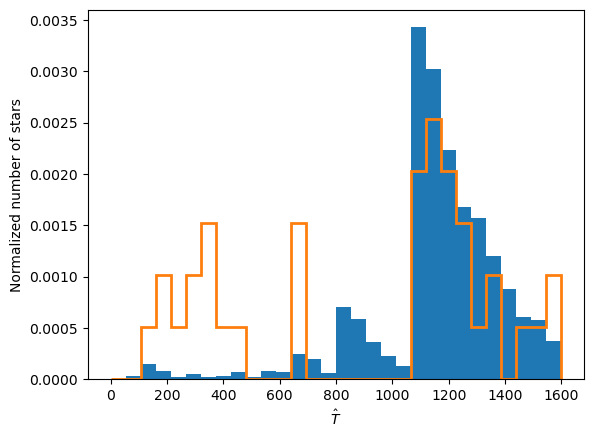

In [13]:
bins = np.linspace(0, 1600, 31)
plt.hist(periods, bins=bins, density=True)
plt.hist(periods[label == 2], bins=bins, density=True, histtype='step', linewidth=2)
plt.xlabel("$\hat T$")
plt.ylabel("Normalized number of stars")
plt.show()

In [14]:
cluster.close()